<a href="https://colab.research.google.com/github/kimdesok/FinanceDataReader/blob/master/Short_Sell_Stock_daily.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Covid data and its relation to the price and returns of an example stock....

##1. Setting libraries and environment
> * importing libraries for data manipulation, graphics, trend indicator calculation, etc
> * Downloading stock data and preparing them for the further processing

## Module that scrapes the data from NAVER and KRX


In [7]:
!pip install pykrx

from pykrx import stock
from pykrx import bond

In [8]:
import urllib
import time
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
 
from urllib.request import urlopen
import seaborn as sns


In [9]:
!pip install finance-datareader

#Ta-Lib library installation for calculating trend indicators

url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h516909a_0.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py37ha21ca33_2.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.7/dist-packages/ lib/python3.7/site-packages/talib --strip-components=3

import talib
import datetime

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3749    0  3749    0     0  18024      0 --:--:-- --:--:-- --:--:-- 18024
100  503k  100  503k    0     0   884k      0 --:--:-- --:--:-- --:--:--  884k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3757    0  3757    0     0  17474      0 --:--:-- --:--:-- --:--:-- 17556
100  406k  100  406k    0     0   714k      0 --:--:-- --:--:-- --:--:--  714k



### Downloading the stock data

In [55]:
import FinanceDataReader as fdr
from datetime import date

def get_codes(my_file, names):
  df = pd.read_csv(my_file, encoding='euc-kr', dtype=object)
  code_list = {}
  for name in names:
    code = df.query("names=='{}'".format(name))['codes'].to_string(index=False)
    code = code.strip()
    code_list[name] = code
  return code_list

In [76]:
def short_graphs(full_df, short_df):

    key0, key1, key2 = full_df.columns[3], short_df.columns[0], short_df.columns[1] # 'Close, Volume, Balance'
   
    
    #Data transform using the closing price
    full_df = full_df.pivot_table(index='Date', values=[key0, 'Volume'])
    
    #Join stock and short sell dataframes

    # Ratio between short sell volume and trade volume
    full_df['Short_interest'] = (short_df[key1]/full_df['Volume']).fillna(0).rolling(5).mean()

    # Difference between the short volume vs. the 1 day balance difference
    full_df['Return_volume'] = (short_df[key1] - short_df[key2].diff()).fillna(0).rolling(5).mean()
  
    plt.figure(figsize = (15,8))
    plt.plot(full_df[key0]/full_df[key0].max(), color = 'darkblue', label ='Price', marker='.', linewidth=2)
    plt.plot((full_df[key0]/full_df[key0].max()).fillna(0).ewm(50).mean(), color = 'aqua', label ='Price 50 day ewma', linestyle ='--', linewidth=2 )
    plt.plot(short_df[key1]/short_df[key1].max().fillna(0).rolling(5).mean(), color = 'orange', label='Trading Volume', alpha=0.5)
    plt.plot(short_df[key2][:-2]/short_df[key2][:-2].max().fillna(0).rolling(5).mean(), color = 'red', label='Accum. Balance', alpha=0.5)
    plt.plot(full_df['Short_interest'], color = 'green', label='Short_interest', linewidth=2)
    plt.plot(full_df['Return_volume']/short_df[key1].max(), color = 'lightblue', label='Return Volume', linewidth=2)

    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Fractional Change')
    plt.title(key0 +': Relation between the price and short sells')
    plt.legend()
    plt.grid(True)

    plt.show()  # show the plot

    plt.clf()  # clear the plot space
    print('\n')
  
def stock_trends(Company_names, code, full_df):

    #Set the beginning date for the analysis
    start_date = full_df.index[0]
    #end_date = full_df.index[-1] 
    end_date = date.today()
    #print('Displaying the data from ', start_date, 'to ', end_date, '\n')
  
    key0 = Company_names['ENG']
    plt.figure(figsize = (15,8))
    plt.plot(full_df[key0], color = 'blue', label ='Price', marker='.')
    plt.plot(full_df[key0].ewm(50).mean(), color = 'aqua', label ='Price 50 day emva')

    plt.xlabel('Date')
    plt.xticks(rotation=45)
    plt.ylabel('Price Change')
    plt.title(key0)
    plt.legend()
    plt.grid(True)

    plt.show()  # show the plot

    plt.clf()  # clear the plot space
    print('\n')

def xshort_graphs(my_file):
  short_df = pd.read_csv(my_file, encoding='cp949')

  #sort the short sell data
  short_df['Date'] = pd.to_datetime(short_df[short_df.columns[0]])
  short_df = short_df.pivot_table(index='Date', values=[short_df.columns[1], short_df.columns[4]])

  columns=[short_df.columns[0], short_df.columns[1]]
  short_df= short_df[columns]

  short_df = short_df.rename({short_df.columns[0]:'Volume', short_df.columns[1]: 'Balance'}, axis=1)

  # Set the index column and sort the short sell data
  #short_df = short_df.set_index(short_df['Date']) why not?
  short_df = short_df.sort_index()

  short_df['Balance_diff'] = short_df['Balance'].diff()
  short_df['Repay_volume'] = (short_df['Volume'] - short_df['Balance_diff']).fillna(0).rolling(5).mean()
  short_df['Balance'] =short_df['Balance'].fillna(0).rolling(5).mean()
  short_df['Volume'] = short_df['Volume'].fillna(0).rolling(5).mean()
  #Set the beginning date for the analysis
  start_date = short_df.index[0]
  #end_date = short_df.index[-1] 

  end_date = date.today()

  print('Displaying the data from ', start_date, 'to ', end_date, '\n')

  plt.figure(figsize = (15,8))

  plt.plot(short_df['Volume'], color = 'green',  label='Trading Volume')
  plt.plot(short_df['Repay_volume'][:-2], color = 'blue', label='Repayment Volume', linewidth=2)
  plt.plot(short_df['Balance'][:-2], color = 'orange', label='Accum. Balance')

  plt.xlabel('Date')
  plt.xticks(rotation=45)
  plt.ylabel('Short Data')
  plt.title(my_file)
  plt.legend()
  plt.grid(True)
  plt.show()  # show the plot

  return short_df

##2. Brief EDA
> * Calculate the correlation between the price and the short volume and balance

{'SK바이오사이언스': '302440', '씨젠': '096530', '피씨엘': '241820', '프레스티지바이오파마': '950210', '삼성전자': '005930', '셀트리온': '068270', '현대자동차': '005380', '대한항공': '003490', '호텔신라': '008770', 'HK이노엔': '195940', '크래프톤': '259960'}
Displaying the data from  20210101 to  20220313 



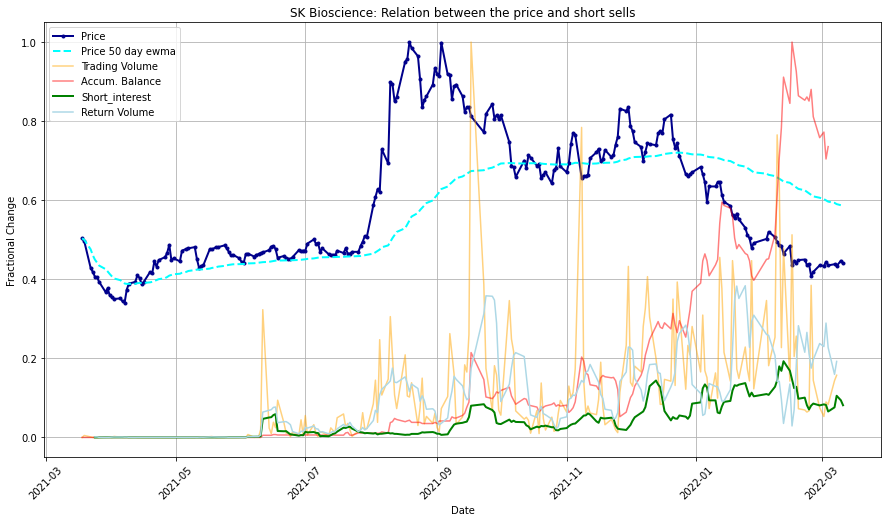

<Figure size 432x288 with 0 Axes>

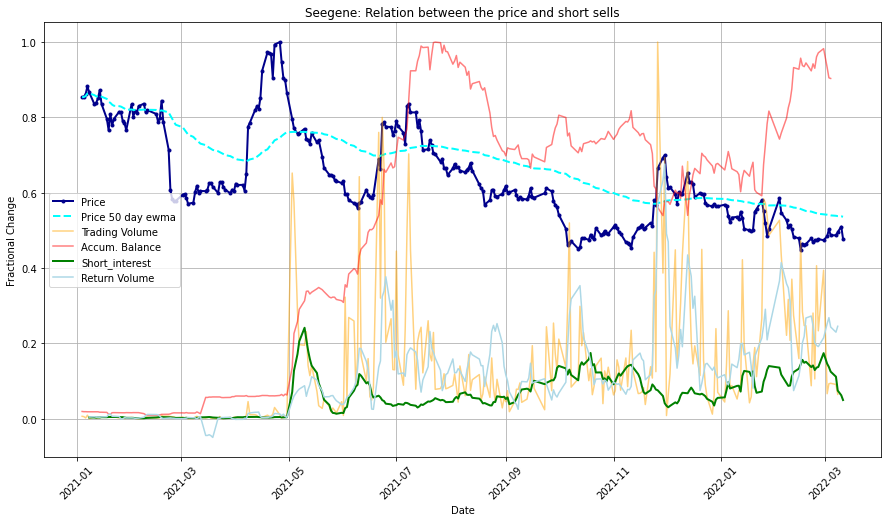

<Figure size 432x288 with 0 Axes>

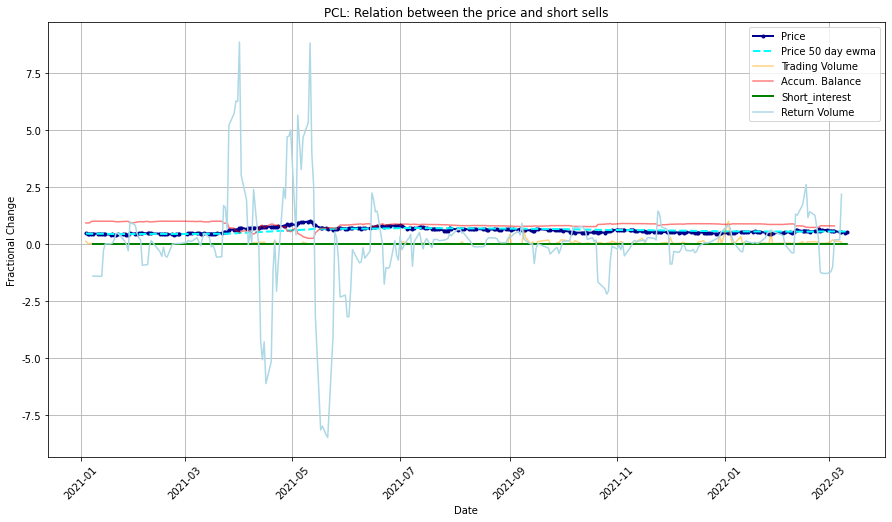

<Figure size 432x288 with 0 Axes>

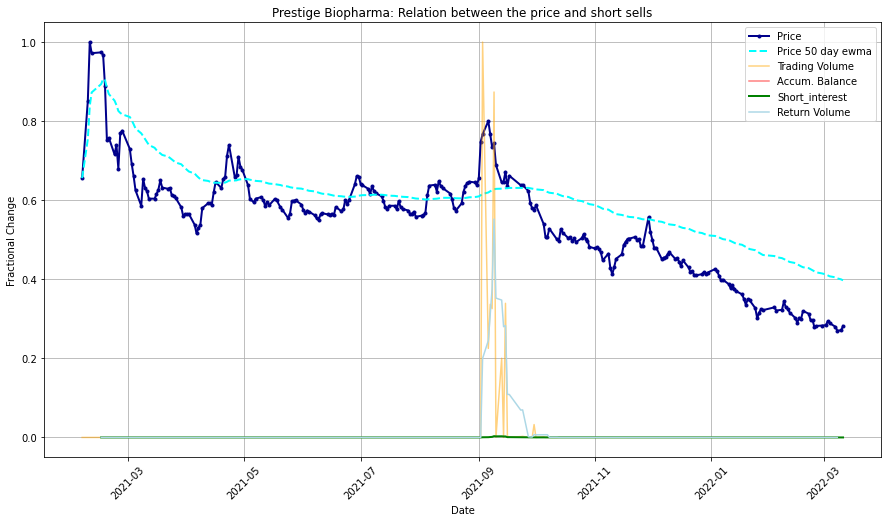

<Figure size 432x288 with 0 Axes>

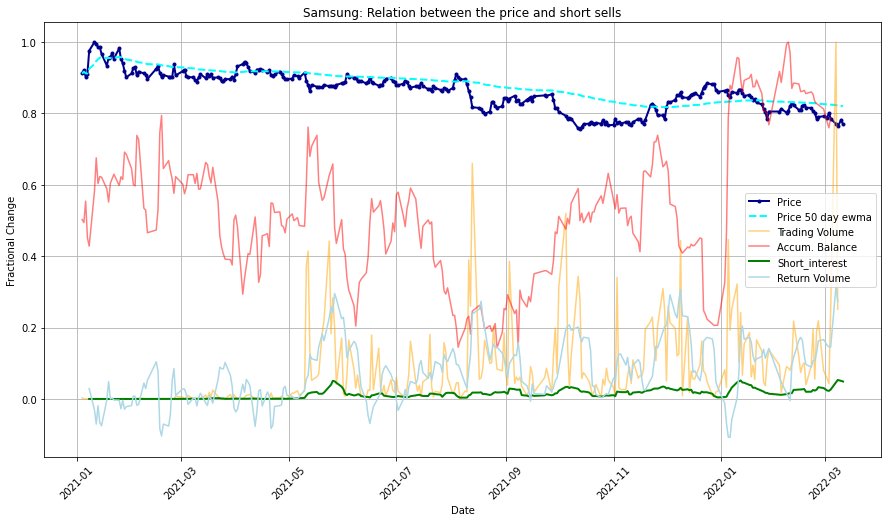

<Figure size 432x288 with 0 Axes>

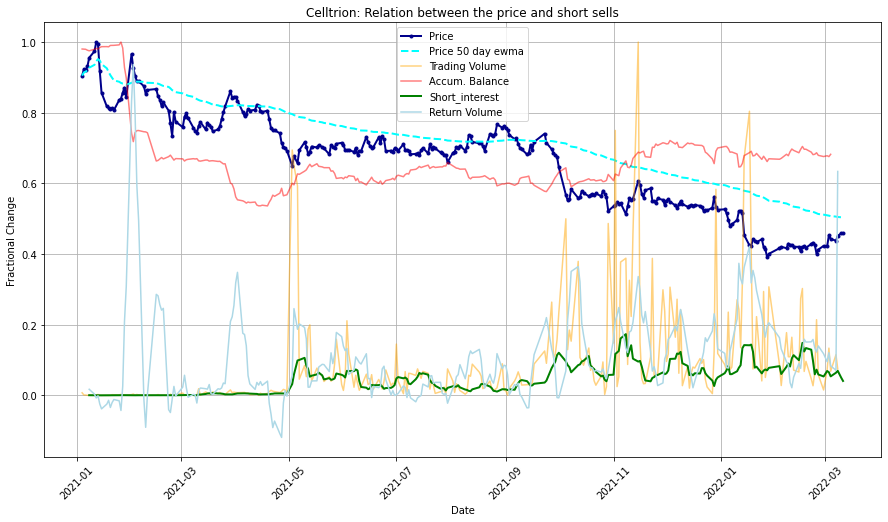

<Figure size 432x288 with 0 Axes>

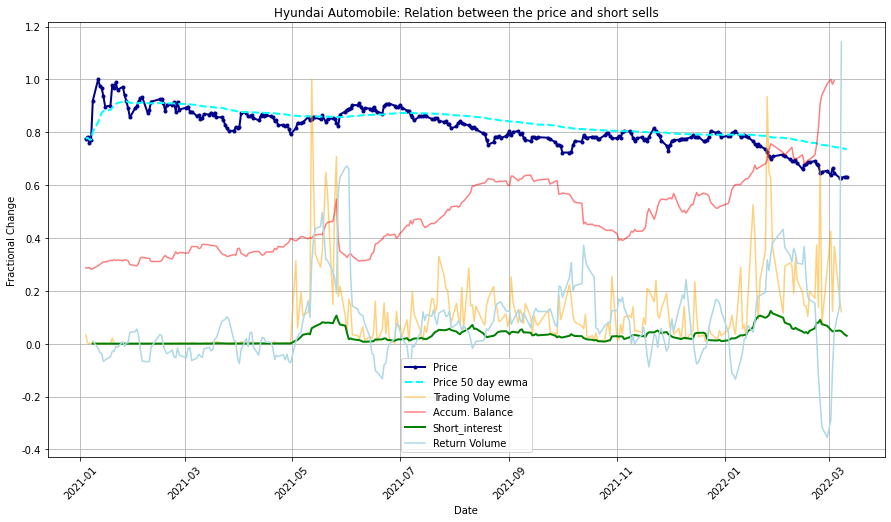

<Figure size 432x288 with 0 Axes>

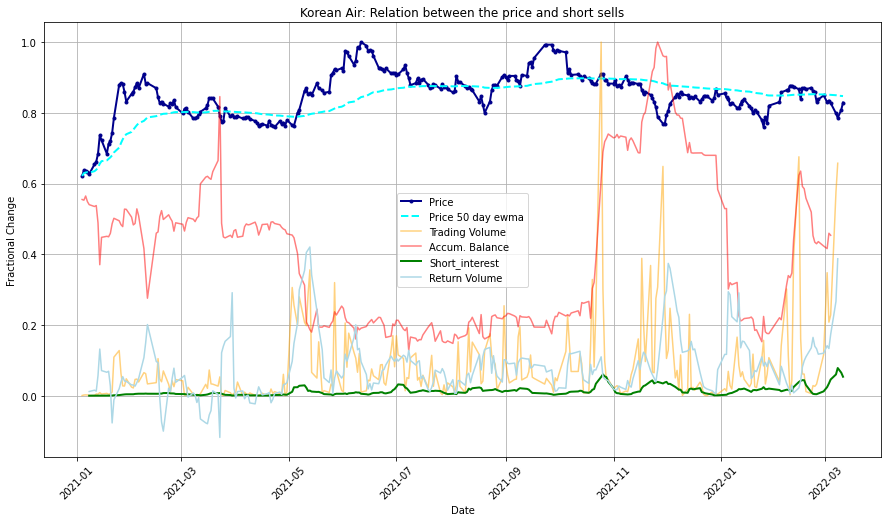

<Figure size 432x288 with 0 Axes>

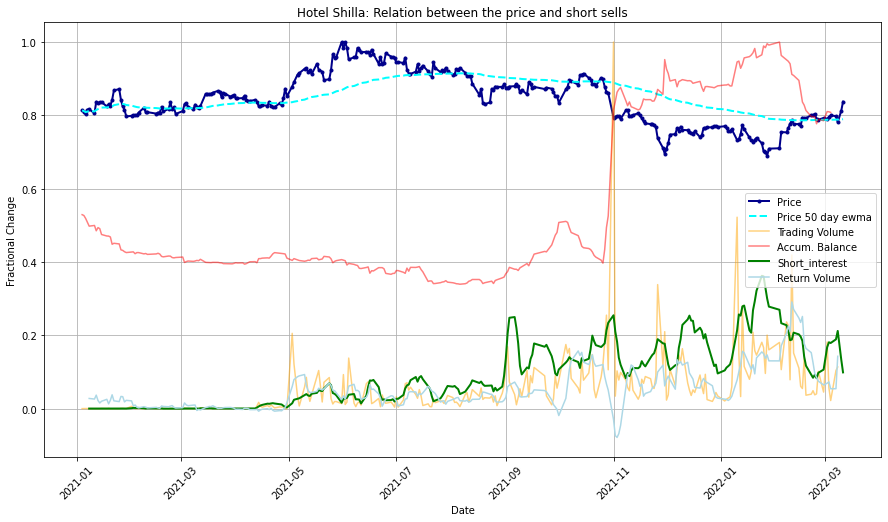

<Figure size 432x288 with 0 Axes>

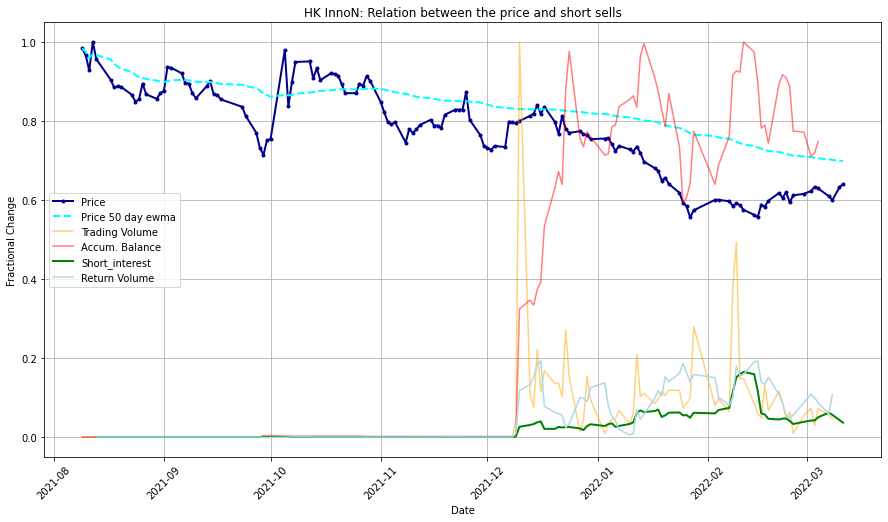

<Figure size 432x288 with 0 Axes>

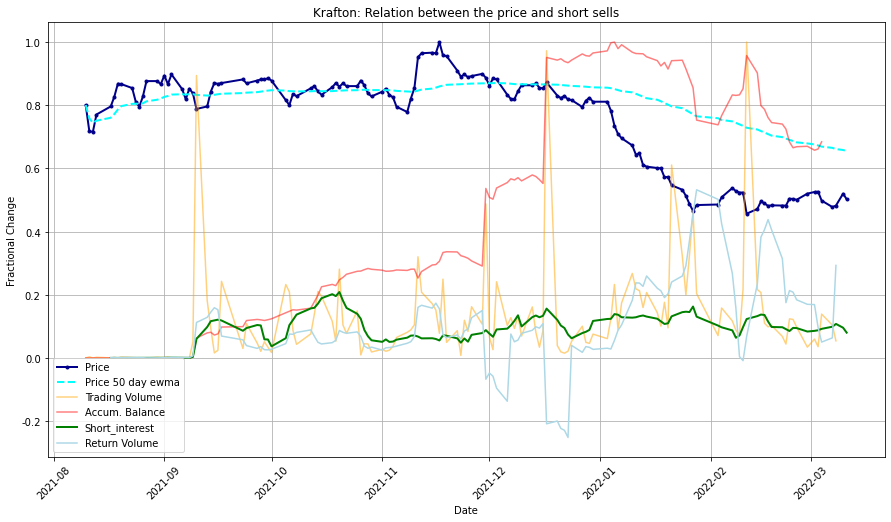

<Figure size 432x288 with 0 Axes>

In [74]:
#For this exercise, we need dataframes representing the stock perfromance of many companies.
Company_names = {'SK바이오사이언스':'SK Bioscience', '씨젠':'Seegene', '피씨엘':'PCL', '프레스티지바이오파마':'Prestige Biopharma', \
                '삼성전자':'Samsung','셀트리온':'Celltrion', '현대자동차':'Hyundai Automobile', \
                '대한항공':'Korean Air', '호텔신라':'Hotel Shilla', 'HK이노엔':'HK InnoN', '크래프톤':'Krafton'}

# Ticker data
my_codes = '/content/drive/MyDrive/datasets/stock_codes.csv'
code_list = get_codes(my_codes, Company_names)
print(code_list)

#Set the beginning date for the analysis
start_date = '20210101'
end_date = date.today().strftime('%Y%m%d')
#end_date = "20220310"
print('Displaying the data from ', start_date, 'to ', end_date, '\n')

for name in Company_names:

  # Ticker
  code = code_list[name]

  # Load the short data
  short_df = stock.get_shorting_status_by_date(start_date, end_date, code)
  short_df.rename({short_df.columns[0]:'Volume', short_df.columns[1]: 'Balance'}, axis=1, inplace=True)

  # Load the stock market data from start_date to today
  full_df = fdr.DataReader(code, start_date, end_date)

  #Name the dataframe with the company name in English which is the label parameter
  full_df.rename({'Close':Company_names[name]}, axis=1, inplace=True)
  short_graphs(full_df, short_df)

